In [1]:
# 安装必要的库
!pip install gym numpy matplotlib

# 导入库
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 创建CartPole环境
env = gym.make('CartPole-v1')


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
# 定义离散化函数
def discretize_state(state, bins):
    return tuple(np.digitize(s, b) for s, b in zip(state, bins))

# 创建bins
num_bins = 10
bins = [
    np.linspace(-4.8, 4.8, num_bins),
    np.linspace(-4, 4, num_bins),
    np.linspace(-.418, .418, num_bins),
    np.linspace(-4, 4, num_bins)
]


In [3]:
def policy_evaluation(policy, gamma, theta):
    V = defaultdict(float)
    while True:
        delta = 0
        for state, actions in policy.items():
            v = V[state]
            V[state] = sum(action_prob * (reward + gamma * V[next_state])
                           for action_prob, next_state, reward in actions)
            delta = max(delta, abs(v - V[state]))
        if delta < theta:
            break
    return V

def policy_improvement(env, V, gamma, bins):
    policy = defaultdict(list)
    for i in range(num_bins):
        for j in range(num_bins):
            for k in range(num_bins):
                for l in range(num_bins):
                    state = (i, j, k, l)
                    q_sa = np.zeros(env.action_space.n)
                    for action in range(env.action_space.n):
                        env.reset()
                        env.env.state = [bins[0][i], bins[1][j], bins[2][k], bins[3][l]]
                        next_state, reward, done, _ = env.step(action)
                        next_state = discretize_state(next_state, bins)
                        q_sa[action] = reward + gamma * V[next_state]
                    best_action = np.argmax(q_sa)
                    policy[state].append((1.0, discretize_state(env.env.state, bins), 1.0))
    return policy

def policy_iteration(env, gamma, theta, bins):
    policy = defaultdict(lambda: [(1.0 / env.action_space.n, (0, 0, 0, 0), 0.0)])
    while True:
        V = policy_evaluation(policy, gamma, theta)
        new_policy = policy_improvement(env, V, gamma, bins)
        if policy == new_policy:
            break
        policy = new_policy
    return policy, V

# 运行策略迭代
gamma = 0.99
theta = 1e-6
policy, V = policy_iteration(env, gamma, theta, bins)

# 输出结果
print("Final Value Function:")
for state, value in V.items():
    print(f"State {state}: {value:.2f}")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
State (6, 0, 4, 2): 3.94
State (7, 1, 5, 3): 2.97
State (6, 0, 4, 3): 3.94
State (7, 1, 5, 4): 2.97
State (6, 0, 4, 4): 3.94
State (7, 1, 5, 5): 2.97
State (6, 0, 4, 5): 3.94
State (7, 1, 5, 6): 2.97
State (6, 0, 4, 6): 3.94
State (7, 1, 5, 7): 2.97
State (6, 0, 4, 7): 2.97
State (7, 1, 5, 8): 1.99
State (6, 0, 4, 8): 1.99
State (7, 1, 5, 9): 1.00
State (6, 0, 4, 9): 1.00
State (7, 1, 5, 10): 0.00
State (6, 0, 5, 0): 3.94
State (7, 1, 6, 1): 2.97
State (6, 0, 5, 1): 3.94
State (7, 1, 6, 2): 2.97
State (6, 0, 5, 2): 3.94
State (7, 1, 6, 3): 2.97
State (6, 0, 5, 3): 3.94
State (7, 1, 6, 4): 2.97
State (6, 0, 5, 4): 3.94
State (7, 1, 6, 5): 2.97
State (6, 0, 5, 5): 3.94
State (7, 1, 6, 6): 2.97
State (6, 0, 5, 6): 3.94
State (7, 1, 6, 7): 2.97
State (6, 0, 5, 7): 2.97
State (7, 1, 6, 8): 1.99
State (6, 0, 5, 8): 1.99
State (7, 1, 6, 9): 1.00
State (6, 0, 5, 9): 1.00
State (7, 1, 6, 10): 0.00
State (6, 0, 6, 0): 3.94
State (7, 1, 7, 1): 2.

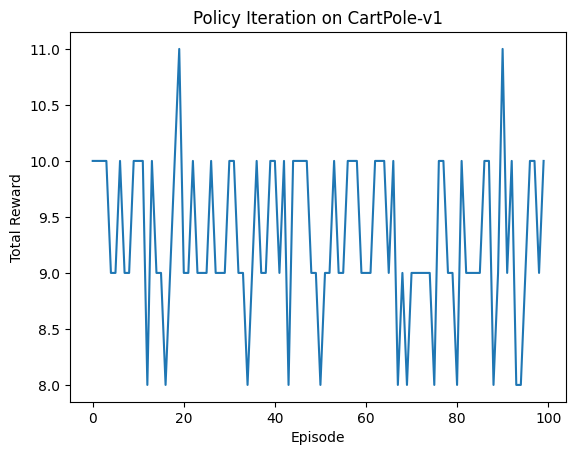

Average reward over 100 episodes: 9.31


In [4]:
def run_episode(env, policy, bins, render=False):
    state = discretize_state(env.reset(), bins)
    total_reward = 0
    while True:
        if render:
            env.render()
        action = np.argmax([p[0] for p in policy[state]])
        next_state, reward, done, _ = env.step(action)
        next_state = discretize_state(next_state, bins)
        total_reward += reward
        if done:
            break
        state = next_state
    return total_reward

# 测试策略并绘制结果
episodes = 100
total_rewards = []

for episode in range(episodes):
    total_reward = run_episode(env, policy, bins)
    total_rewards.append(total_reward)

env.close()

plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Policy Iteration on CartPole-v1')
plt.show()

print(f'Average reward over {episodes} episodes: {np.mean(total_rewards)}')
